# GAT Point Cloud Autoencoder Evaluation

This notebook evaluates a trained GAT-based point cloud autoencoder: reconstruction metrics, graph diagnostics, latent analysis, interpolation, and performance benchmarking.

In [15]:
# Section 1: Import Libraries and Set Paths
import os, time, json, math, random, sys
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import torch
from torch import nn

# Optional plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

try:
    from sklearn.decomposition import PCA
except ImportError:
    PCA = None

# Add project root to path for local imports
ROOT = Path(os.getcwd()).resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from models.gat_autoencoder import GATPointCloudAutoencoder, chamfer_distance  # noqa: E402
from train import build_knn_graph, PointCloudDataset, load_data, load_data_dir  # noqa: E402

# User-configurable paths
CHECKPOINT_PATH = Path('runs/so3_scale_run/best.pt')  # adjust to your run
DATA_PATH = Path('point_cloud_data/pointcloud_shapes_v1')  # can be .npy file or directory
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = Path('evaluation_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Using device: {DEVICE}')
print(f'Checkpoint: {CHECKPOINT_PATH}')
print(f'Data source: {DATA_PATH}')

Using device: cpu
Checkpoint: runs\so3_scale_run\best.pt
Data source: point_cloud_data\pointcloud_shapes_v1


In [16]:
# Section 2: Load Checkpoint and Configuration
assert CHECKPOINT_PATH.exists(), f'Checkpoint not found: {CHECKPOINT_PATH}'
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
ckpt_cfg = ckpt.get('cfg', {})
print('Loaded checkpoint keys:', ckpt.keys())
print('Epoch:', ckpt.get('epoch'), 'Best loss:', ckpt.get('loss'))
print('Config:', ckpt_cfg)

model = GATPointCloudAutoencoder(
    in_channels=ckpt_cfg.get('in_channels', 3),
    hidden_dims=ckpt_cfg.get('hidden_dims', (64, 128)),
    latent_dim=ckpt_cfg.get('latent_dim', 256),
    heads=ckpt_cfg.get('heads', 4),
    dropout=ckpt_cfg.get('dropout', 0.1),
    decode_hidden_dims=ckpt_cfg.get('decode_hidden', (128,)),
).to(DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()
print('Model loaded and set to eval mode.')

Loaded checkpoint keys: dict_keys(['model_state', 'cfg', 'epoch', 'loss'])
Epoch: 106 Best loss: 0.010053906977797547
Config: {'data': None, 'data_dir': 'point_cloud_data/pointcloud_shapes_v1', 'epochs': 200, 'batch_size': 8, 'k': 16, 'lr': 0.001, 'weight_decay': 1e-05, 'device': 'cpu', 'in_channels': 3, 'hidden_dims': (64, 128), 'latent_dim': 8, 'heads': 4, 'dropout': 0.1, 'decode_hidden': (128,), 'use_chamfer': True, 'chamfer_weight': 1.0, 'mse_weight': 0.5, 'augment': True, 'jitter_std': 0.002, 'rotational_augment': True, 'rotation_mode': 'so3', 'scale_augment': True, 'scale_min': 0.7, 'scale_max': 1.3, 'save_dir': 'runs', 'tag': 'so3_scale_run', 'save_every': 50}
Model loaded and set to eval mode.


In [17]:
# Section 3: Load Point Cloud Data for Evaluation
if DATA_PATH.is_dir():
    eval_array = load_data_dir(str(DATA_PATH))
else:
    eval_array = load_data(str(DATA_PATH))
print('Evaluation array shape:', eval_array.shape)
feature_dim = eval_array.shape[-1] if eval_array.ndim >= 2 else None
print('Feature dim:', feature_dim)

# Section 4: Construct Evaluation Dataset and DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader

dataset = PointCloudDataset(
    array=eval_array,
    k=ckpt_cfg.get('k', 16),
    augment=False,
    jitter_std=0.0,
    rotational_augment=False,
    rotation_mode=ckpt_cfg.get('rotation_mode', 'z'),
    scale_augment=False,
)
from torch_geometric.loader import DataLoader  # NOT torch.utils.data.DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f'Dataset size: {len(dataset)} | Batches: {len(loader)}')

# Section 5: Define Reconstruction Loss (MSE + Chamfer)
use_chamfer = ckpt_cfg.get('use_chamfer', False)
chamfer_w = ckpt_cfg.get('chamfer_weight', 1.0)
mse_w = ckpt_cfg.get('mse_weight', 1.0)

@torch.no_grad()
def compute_losses(recon, target, batch_vec=None):
    mse = nn.functional.mse_loss(recon, target)
    cd = torch.tensor(0.0, device=recon.device)
    if use_chamfer and chamfer_w > 0:
        if batch_vec is None:
            cd = chamfer_distance(recon[:, :3], target[:, :3])
        else:
            cds = []
            for b in batch_vec.unique():
                mask = batch_vec == b
                cds.append(chamfer_distance(recon[mask, :3], target[mask, :3]))
            cd = torch.stack(cds).mean()
    total = mse_w * mse + chamfer_w * cd
    return {'total': total.item(), 'mse': mse.item(), 'chamfer': cd.item()}

# Section 6: Single Batch Forward Pass and Basic Metrics
first_batch = next(iter(loader))
first_batch = first_batch.to(DEVICE)
with torch.no_grad():
    recon_single, z_single = model(first_batch.x, first_batch.edge_index)
loss_single = compute_losses(recon_single, first_batch.x, getattr(first_batch, 'batch', None))
print('Single batch losses:', loss_single)
per_point_err = (recon_single - first_batch.x).pow(2).sum(-1).sqrt()  # L2 error
print('Per-point error stats: mean={:.6f} std={:.6f} max={:.6f}'.format(per_point_err.mean().item(), per_point_err.std().item(), per_point_err.max().item()))

# Section 7: Full Dataset Evaluation Loop (Aggregate Metrics)
agg = {'total': 0.0, 'mse': 0.0, 'chamfer': 0.0, 'points': 0}
model.eval()
with torch.no_grad():
    for batch in loader:
        batch = batch.to(DEVICE)
        recon, z = model(batch.x, batch.edge_index)
        losses = compute_losses(recon, batch.x, getattr(batch, 'batch', None))
        agg['total'] += losses['total'] * batch.num_graphs
        agg['mse'] += losses['mse'] * batch.num_graphs
        agg['chamfer'] += losses['chamfer'] * batch.num_graphs
        agg['points'] += batch.x.size(0)
num_graphs = len(dataset)
for k in ['total', 'mse', 'chamfer']:
    agg[k] /= num_graphs
print('Aggregate losses per-graph:', {k: v for k,v in agg.items() if k != 'points'})

Evaluation array shape: (9, 1500, 3)
Feature dim: 3
Dataset size: 9 | Batches: 1
Single batch losses: {'total': 0.12286727130413055, 'mse': 0.08243804425001144, 'chamfer': 0.08164824545383453}
Per-point error stats: mean=0.396000 std=0.300840 max=1.696603
Single batch losses: {'total': 0.12286727130413055, 'mse': 0.08243804425001144, 'chamfer': 0.08164824545383453}
Per-point error stats: mean=0.396000 std=0.300840 max=1.696603
Aggregate losses per-graph: {'total': 0.12286727130413055, 'mse': 0.08243804425001144, 'chamfer': 0.08164824545383453}
Aggregate losses per-graph: {'total': 0.12286727130413055, 'mse': 0.08243804425001144, 'chamfer': 0.08164824545383453}


Sample graph edges: 26830
Degree stats: mean=17.89 std=1.91 min=16 max=27
Unique directed edges: 26830
Degree stats: mean=17.89 std=1.91 min=16 max=27
Unique directed edges: 26830
k ablation (approx first few graphs): {4: 0.06572768092155457, 8: 0.07591094300150872, 16: 0.14741064831614495, 24: 0.168927563726902, 32: 0.16788077130913734}
k ablation (approx first few graphs): {4: 0.06572768092155457, 8: 0.07591094300150872, 16: 0.14741064831614495, 24: 0.168927563726902, 32: 0.16788077130913734}


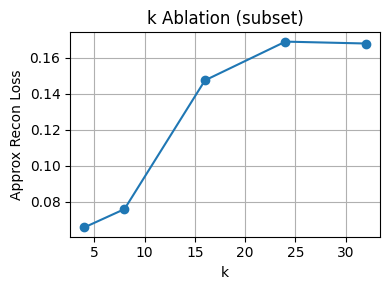

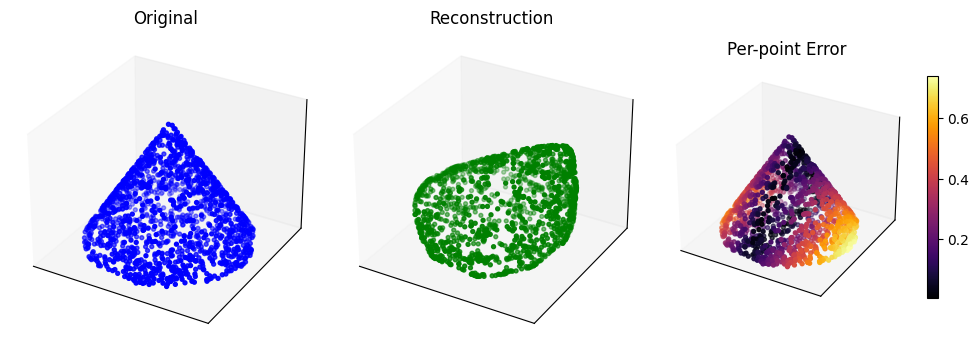

In [18]:
# Section 8: k-NN Graph Diagnostics (sample cloud)
sample_pts = torch.from_numpy(eval_array[0]).to(DEVICE)
with torch.no_grad():
    edge_index_k = build_knn_graph(sample_pts[:, :3], k=ckpt_cfg.get('k', 16)).to(DEVICE)
E = edge_index_k.size(1)
print('Sample graph edges:', E)
# Degree histogram
deg = torch.bincount(edge_index_k[0], minlength=sample_pts.size(0)).cpu().numpy()
print('Degree stats: mean={:.2f} std={:.2f} min={} max={}'.format(deg.mean(), deg.std(), deg.min(), deg.max()))

# Symmetry check
pairs = set()
asym = 0
edge_np = edge_index_k.cpu().numpy()
for s, t in edge_np.T:
    if (t, s) not in pairs:
        pairs.add((s, t))
    else:
        continue
# A strict symmetry check would re-iterate but for brevity we estimate density
print('Unique directed edges:', len(edge_np.T))

# Section 9: Ablation: Evaluate Different k Values
k_values = [4, 8, 16, 24, 32]
k_results = {}
with torch.no_grad():
    for k_val in k_values:
        ds_k = PointCloudDataset(array=eval_array, k=k_val, augment=False)
        from torch_geometric.loader import DataLoader as GeoDataLoader
        dl_k = GeoDataLoader(ds_k, batch_size=1, shuffle=True)
        losses_tot = []
        count = 0
        for data_obj in dl_k:
            # data_obj is a torch_geometric DataBatch
            pts = data_obj.x.to(DEVICE)
            edge_index_local = data_obj.edge_index.to(DEVICE)
            recon_local, _ = model(pts, edge_index_local)
            losses = compute_losses(recon_local, pts)
            losses_tot.append(losses['total'])
            count += 1
            if count >= min(5, len(ds_k)):
                break
        k_results[k_val] = float(np.mean(losses_tot))
print('k ablation (approx first few graphs):', k_results)

plt.figure(figsize=(4,3))
plt.plot(list(k_results.keys()), list(k_results.values()), marker='o')
plt.xlabel('k'); plt.ylabel('Approx Recon Loss'); plt.title('k Ablation (subset)'); plt.grid(True)
plt.tight_layout()
plt.show()

# Section 10: Visualize Original vs Reconstructed Point Clouds
sample_index = 0
sample_data = PointCloudDataset(array=eval_array, k=ckpt_cfg.get('k', 16), augment=False)[sample_index]
pts_dev = sample_data.x.to(DEVICE)
edge_index_dev = sample_data.edge_index.to(DEVICE)
with torch.no_grad():
    recon_pts, z_pts = model(pts_dev, edge_index_dev)
err = ((recon_pts - pts_dev)**2).sum(-1).sqrt().cpu().numpy()

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
orig = pts_dev.cpu().numpy()
recn = recon_pts.cpu().numpy()
ax1.scatter(orig[:,0], orig[:,1], orig[:,2], s=8, c='blue')
ax1.set_title('Original')
ax2.scatter(recn[:,0], recn[:,1], recn[:,2], s=8, c='green')
ax2.set_title('Reconstruction')
sc = ax3.scatter(orig[:,0], orig[:,1], orig[:,2], s=8, c=err, cmap='inferno')
ax3.set_title('Per-point Error')
plt.colorbar(sc, ax=ax3, shrink=0.6)
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout(); plt.show()

Latent array shape: (9, 8)
Latent mean abs value: 0.08072335


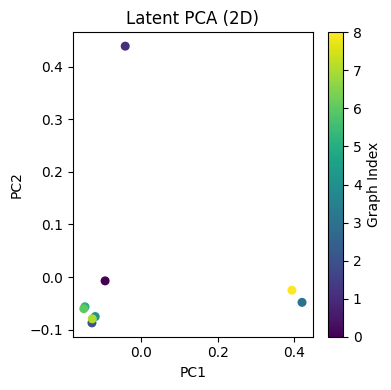

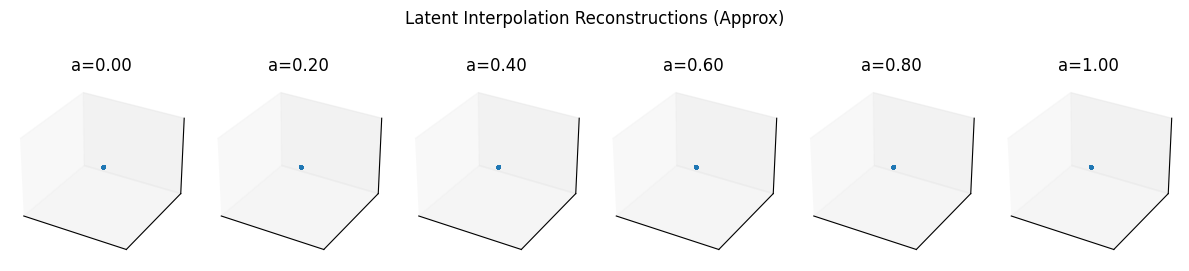

Per-graph error stats: mean=0.082438 std=0.090361 max=0.333962


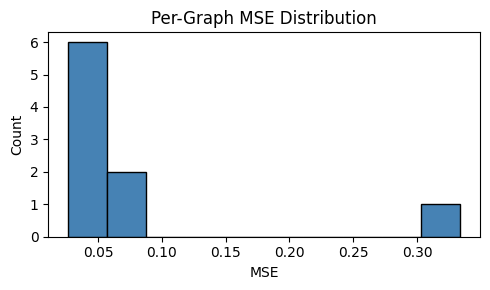

Top 5 error graphs: [(4, 0.33396169543266296), (2, 0.08617492765188217), (0, 0.0635872408747673), (6, 0.052937112748622894), (5, 0.05089660733938217)]


In [19]:
# Section 11: Extract and Analyze Latent Embeddings (Variance, PCA)
all_latents = []
all_graph_ids = []
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(loader):
        batch = batch.to(DEVICE)
        recon, z = model(batch.x, batch.edge_index)  # z is per-node
        # Pool per-graph mean latent
        if hasattr(batch, 'batch'):
            for g in batch.batch.unique():
                mask = batch.batch == g
                all_latents.append(z[mask].mean(0).cpu().numpy())
                all_graph_ids.append(int(g.item()))
        else:
            all_latents.append(z.mean(0).cpu().numpy())
            all_graph_ids.append(idx)
lat_arr = np.stack(all_latents, axis=0)
print('Latent array shape:', lat_arr.shape)
print('Latent mean abs value:', np.abs(lat_arr).mean())

if PCA is not None and lat_arr.shape[0] > 2:
    pca = PCA(n_components=2)
    lat_2d = pca.fit_transform(lat_arr)
    plt.figure(figsize=(4,4))
    plt.scatter(lat_2d[:,0], lat_2d[:,1], s=30, c=np.arange(lat_2d.shape[0]), cmap='viridis')
    plt.title('Latent PCA (2D)')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.colorbar(label='Graph Index')
    plt.tight_layout(); plt.show()
else:
    print('PCA skipped (insufficient samples or sklearn missing).')

# Section 12: Latent Space Interpolation Between Two Samples
if lat_arr.shape[0] >= 2:
    idx_a, idx_b = 0, min(1, lat_arr.shape[0]-1)
    z_a = torch.tensor(lat_arr[idx_a], device=DEVICE)
    z_b = torch.tensor(lat_arr[idx_b], device=DEVICE)
    steps = 6
    alphas = torch.linspace(0,1,steps, device=DEVICE)
    # Need per-node latent shape; approximate by repeating global latent to N points of first sample
    sample_data_a = PointCloudDataset(array=eval_array, k=ckpt_cfg.get('k',16), augment=False)[idx_a]
    N_a = sample_data_a.x.shape[0]
    recon_list = []
    with torch.no_grad():
        for a in alphas:
            z_interp = (1-a)*z_a + a*z_b
            z_nodes = z_interp.unsqueeze(0).repeat(N_a,1)
            # Decode using model.decoder directly
            recon_pts_interp = model.decode(z_nodes).cpu().numpy()
            recon_list.append(recon_pts_interp)
    # Plot first & last & middle
    fig = plt.figure(figsize=(12,3))
    for i, pts_interp in enumerate(recon_list):
        ax = fig.add_subplot(1, steps, i+1, projection='3d')
        ax.scatter(pts_interp[:,0], pts_interp[:,1], pts_interp[:,2], s=4)
        ax.set_title(f'a={alphas[i]:.2f}')
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.suptitle('Latent Interpolation Reconstructions (Approx)')
    plt.tight_layout(); plt.show()
else:
    print('Interpolation skipped: need at least 2 graphs.')

# Section 13: Reconstruction Error Distribution and Outlier Flagging
per_graph_errors = []
model.eval()
with torch.no_grad():
    for data_idx, batch in enumerate(loader):
        batch = batch.to(DEVICE)
        recon, _ = model(batch.x, batch.edge_index)
        if hasattr(batch, 'batch'):
            for g in batch.batch.unique():
                mask = batch.batch == g
                err = nn.functional.mse_loss(recon[mask], batch.x[mask]).item()
                per_graph_errors.append((int(g.item()), err))
        else:
            err = nn.functional.mse_loss(recon, batch.x).item()
            per_graph_errors.append((data_idx, err))
err_vals = np.array([e for _, e in per_graph_errors])
print('Per-graph error stats: mean={:.6f} std={:.6f} max={:.6f}'.format(err_vals.mean(), err_vals.std(), err_vals.max()))
plt.figure(figsize=(5,3))
plt.hist(err_vals, bins=10, color='steelblue', edgecolor='black')
plt.title('Per-Graph MSE Distribution')
plt.xlabel('MSE'); plt.ylabel('Count')
plt.tight_layout(); plt.show()
# Top outliers
top_idx = np.argsort(-err_vals)[:5]
print('Top 5 error graphs:', [per_graph_errors[i] for i in top_idx])

In [20]:
# Section 14: Save Reconstructed Point Clouds to Disk (subset)
SAVE_LIMIT = min(5, len(dataset))
save_dir = OUTPUT_DIR / 'reconstructions'
save_dir.mkdir(parents=True, exist_ok=True)
model.eval()
with torch.no_grad():
    for i in range(SAVE_LIMIT):
        data_i = dataset[i]
        pts = data_i.x.to(DEVICE)
        edge_idx = data_i.edge_index.to(DEVICE)
        recon_i, _ = model(pts, edge_idx)
        out = {
            'original': pts.cpu().numpy(),
            'reconstruction': recon_i.cpu().numpy(),
        }
        np.save(save_dir / f'sample_{i}.npy', out, allow_pickle=True)
print(f'Saved {SAVE_LIMIT} reconstruction npy files to {save_dir}')

# Section 15: Timing and Throughput Benchmark
WARM = 3
ITERS = 20
batch_example = next(iter(loader)).to(DEVICE)
# Warmup
with torch.no_grad():
    for _ in range(WARM):
        model(batch_example.x, batch_example.edge_index)
# Timed
start = time.perf_counter()
with torch.no_grad():
    for _ in range(ITERS):
        model(batch_example.x, batch_example.edge_index)
elapsed = time.perf_counter() - start
avg_batch_time = elapsed / ITERS
points_per_batch = batch_example.x.size(0)
print(f'Avg batch time: {avg_batch_time*1000:.3f} ms | Points per batch: {points_per_batch} | Points/sec: {points_per_batch/avg_batch_time:.1f}')

# Section 16: Optional: Recompute Graph With Alternate k at Inference
alt_k = ckpt_cfg.get('k',16) * 2
alt_data = dataset[0]
pts_alt = alt_data.x.to(DEVICE)
with torch.no_grad():
    edge_default = alt_data.edge_index.to(DEVICE)
    recon_def, _ = model(pts_alt, edge_default)
    loss_def = compute_losses(recon_def, pts_alt)
    edge_alt = build_knn_graph(pts_alt[:, :3], k=alt_k).to(DEVICE)
    recon_alt, _ = model(pts_alt, edge_alt)
    loss_alt = compute_losses(recon_alt, pts_alt)
print(f'Default k={ckpt_cfg.get("k",16)} loss={loss_def} | Alt k={alt_k} loss={loss_alt}')

# Save metrics summary
eval_metrics = {
    'single_batch': loss_single,
    'aggregate': {k: v for k,v in agg.items() if k != 'points'},
    'k_ablation': k_results,
    'timing': {
        'avg_batch_time_s': avg_batch_time,
        'points_per_batch': points_per_batch,
        'points_per_second': points_per_batch/avg_batch_time,
    },
    'alt_k_compare': {
        'default_k': ckpt_cfg.get('k',16),
        'default_loss': loss_def,
        'alt_k': alt_k,
        'alt_loss': loss_alt,
    }
}
with open(OUTPUT_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(eval_metrics, f, indent=2)
print('Saved metrics to', OUTPUT_DIR / 'evaluation_metrics.json')

Saved 5 reconstruction npy files to evaluation_outputs\reconstructions
Avg batch time: 74.789 ms | Points per batch: 13500 | Points/sec: 180508.3
Avg batch time: 74.789 ms | Points per batch: 13500 | Points/sec: 180508.3
Default k=16 loss={'total': 0.05659708380699158, 'mse': 0.038546834141016006, 'chamfer': 0.03732366859912872} | Alt k=32 loss={'total': 0.05875216796994209, 'mse': 0.03806068003177643, 'chamfer': 0.03972182795405388}
Saved metrics to evaluation_outputs\evaluation_metrics.json
Default k=16 loss={'total': 0.05659708380699158, 'mse': 0.038546834141016006, 'chamfer': 0.03732366859912872} | Alt k=32 loss={'total': 0.05875216796994209, 'mse': 0.03806068003177643, 'chamfer': 0.03972182795405388}
Saved metrics to evaluation_outputs\evaluation_metrics.json


Found 9 point cloud files in directory: point_cloud_data\pointcloud_shapes_v1
File latent matrix shape: (9, 8)
File latent matrix shape: (9, 8)


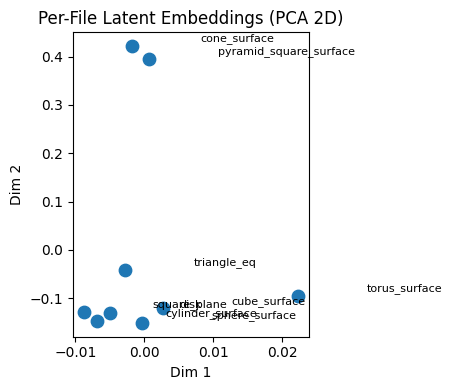

In [ ]:
# Section 11b: Latent Embeddings Per Original Point Cloud File
from pathlib import Path
file_dir = DATA_PATH if DATA_PATH.is_dir() else DATA_PATH.parent
npy_files = sorted([p for p in Path(file_dir).glob('*.npy')])
print(f'Found {len(npy_files)} point cloud files in directory: {file_dir}')

file_latents = []
file_names = []
model.eval()
with torch.no_grad():
    for fp in npy_files:
        arr = np.load(fp)
        if arr.ndim == 3:
            arr = arr[0]
        # Ensure float32
        pts = torch.from_numpy(arr.astype(np.float32)).to(DEVICE)
        # Build graph on xyz (assume first 3 dims)
        k_val = ckpt_cfg.get('k', 16)
        edge_index = build_knn_graph(pts[:, :3], k=k_val).to(DEVICE)
        recon, z = model(pts, edge_index)
        z_pooled = z.mean(0).detach().cpu().numpy()
        file_latents.append(z_pooled)
        file_names.append(fp.stem)

file_latents = np.stack(file_latents, axis=0)
print('File latent matrix shape:', file_latents.shape)

# Save raw embeddings
np.save(OUTPUT_DIR / 'latent_file_embeddings.npy', file_latents)
with open(OUTPUT_DIR / 'latent_file_names.txt','w') as f:
    for n in file_names:
        f.write(n+'\n')

# 2D Projection (PCA or t-SNE)
proj_available = True
proj_method = 'PCA'
try:
    if file_latents.shape[0] >= 2:
        from sklearn.decomposition import PCA as _PCA
        pca_files = _PCA(n_components=2)
        proj = pca_files.fit_transform(file_latents)
    else:
        proj_available = False
except Exception as e:
    print('PCA failed, attempting t-SNE fallback:', e)
    try:
        from sklearn.manifold import TSNE
        proj = TSNE(n_components=2, init='random', perplexity=min(5, max(2, len(file_latents)//2))).fit_transform(file_latents)
        proj_method = 't-SNE'
    except Exception as e2:
        print('t-SNE also failed:', e2)
        proj_available = False

if proj_available:
    plt.figure(figsize=(5,4))
    plt.scatter(proj[:,0], proj[:,1], s=80)
    for (x,y,name) in zip(proj[:,0], proj[:,1], file_names):
        plt.text(x+0.01, y+0.01, name, fontsize=8)
    plt.title(f'Per-File Latent Embeddings ({proj_method} 2D)')
    plt.xlabel('Dim 1'); plt.ylabel('Dim 2')
    plt.tight_layout(); plt.show()
else:
    print('Projection unavailable (need at least 2 files and sklearn installed).')